## SETUP

In [1]:
import os
os.getcwd()

'C:\\Users\\HP\\Desktop\\chi-limited-analysis-py311\\notebooks'

## IMPORTS & CONFIGURATION

In [2]:
# ============================================================================
# CHI LIMITED - PROMOTIONAL EFFECTIVENESS ANALYSIS
# Notebook 03: ROI, Discounts, Cannibalization
# ============================================================================

import pandas as pd
import numpy as np
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
sns.set_palette("Set2")

print("✅ Libraries imported!")

✅ Libraries imported!


#### Load Data

In [5]:
# ============================================================================
# LOAD DATA
# ============================================================================

conn = sqlite3.connect('../chi_limited.db')

# Load all necessary tables
df_sales = pd.read_sql_query("SELECT * FROM fact_sales", conn)
df_promotions = pd.read_sql_query("SELECT * FROM fact_promotions", conn)
df_product = pd.read_sql_query("SELECT * FROM dim_product", conn)
df_time = pd.read_sql_query("SELECT * FROM dim_time", conn)
df_geography = pd.read_sql_query("SELECT * FROM dim_geography", conn)

# Load promotional effectiveness view
df_promo_effectiveness = pd.read_sql_query(
    "SELECT * FROM v_promotional_effectiveness", 
    conn
)

print(f"✅ Data loaded:")
print(f"   Promotions: {len(df_promotions)} campaigns")
print(f"   Promo Effectiveness View: {len(df_promo_effectiveness)} records")

✅ Data loaded:
   Promotions: 323 campaigns
   Promo Effectiveness View: 310 records


In [6]:
# ============================================================================
# ENSURE OUTPUT DIRECTORIES EXIST (FIXES SAVE ERRORS)
# ============================================================================

import os

os.makedirs("../docs/images", exist_ok=True)

print("✅ Output folders verified: ../docs/images/")


✅ Output folders verified: ../docs/images/


#### Calculating Comprehensive Promo Metrics

In [8]:
# ============================================================================
# PROMOTIONAL METRICS CALCULATION
# ============================================================================

print("📊 Calculating promotional metrics...")

# Helper function to convert ISO week (YYYY-Www) to a date
def iso_week_to_date(iso_week):
    # Converts 'YYYY-Www' → Monday of that ISO week
    return pd.to_datetime(iso_week + '-1', format='%Y-W%W-%w')

# Merge promotions with sales to get actual performance
promo_sales = []

for idx, promo in df_promotions.iterrows():
    # Get sales during promo period
    sales_during_promo = df_sales[
        (df_sales['product_id'] == promo['product_id']) &
        (df_sales['region_id'] == promo['region_id']) &
        (df_sales['channel_id'] == promo['channel_id']) &
        (df_sales['week_id'] >= promo['promo_start_week']) &
        (df_sales['week_id'] <= promo['promo_end_week'])
    ]
    
    if len(sales_during_promo) > 0:
        # Aggregate metrics
        total_revenue = sales_during_promo['revenue_ngn'].sum()
        total_units = sales_during_promo['units_sold'].sum()
        baseline = sales_during_promo['baseline_demand'].sum()
        incremental_units = total_units - baseline
        
        # Calculate ROI
        promo_cost = promo['promo_cost_ngn']
        roi = (total_revenue - promo_cost) / promo_cost if promo_cost > 0 else 0
        
        # Calculate uplift
        uplift_pct = (incremental_units / baseline * 100) if baseline > 0 else 0
        
        # Duration (FIXED — ISO week parsing)
        duration = (
            iso_week_to_date(promo['promo_end_week']) -
            iso_week_to_date(promo['promo_start_week'])
        ).days / 7 + 1
        
        promo_sales.append({
            'promo_id': promo['promo_id'],
            'product_id': promo['product_id'],
            'region_id': promo['region_id'],
            'channel_id': promo['channel_id'],
            'promo_type': promo['promo_type'],
            'discount_percentage': promo['discount_percentage'],
            'promo_cost_ngn': promo_cost,
            'total_revenue': total_revenue,
            'total_units': total_units,
            'baseline_demand': baseline,
            'incremental_units': incremental_units,
            'roi': roi,
            'uplift_pct': uplift_pct,
            'duration_weeks': duration,
            'cost_per_incremental_unit': promo_cost / incremental_units if incremental_units > 0 else 0
        })

df_promo_metrics = pd.DataFrame(promo_sales)

# Merge with product info
df_promo_metrics = df_promo_metrics.merge(
    df_product[['product_id', 'product_name', 'category', 'brand']], 
    on='product_id', 
    how='left'
)

print(f"✅ Metrics calculated for {len(df_promo_metrics)} campaigns")
print()
print("Sample data:")
print(df_promo_metrics[['promo_type', 'discount_percentage', 'roi', 'uplift_pct']].head(10))


📊 Calculating promotional metrics...
✅ Metrics calculated for 323 campaigns

Sample data:
  promo_type  discount_percentage        roi  uplift_pct
0  Price_Off                 10.0  10.100567  183.271605
1  Price_Off                 15.0   7.001985   49.458943
2     Bundle                 15.0  -0.051707   53.486239
3  Price_Off                 15.0   1.810795  100.700219
4      BOGOF                 50.0   1.865531  144.360087
5     Bundle                 15.0   0.413024    8.191126
6  Price_Off                 10.0   1.413435   50.471698
7      BOGOF                 50.0  -0.488943   92.096506
8      BOGOF                 50.0   0.763708  274.172494
9  Price_Off                 25.0   1.145772   67.768038


#### ROI by Promo Type

In [9]:
# ============================================================================
# ANALYSIS 1: ROI BY PROMO TYPE
# ============================================================================

print("📊 ROI Analysis by Promotion Type...")

roi_by_type = df_promo_metrics.groupby('promo_type').agg({
    'roi': ['mean', 'median', 'std', 'count'],
    'uplift_pct': 'mean',
    'cost_per_incremental_unit': 'mean'
}).round(2)

roi_by_type.columns = ['_'.join(col).strip() for col in roi_by_type.columns.values]
roi_by_type = roi_by_type.reset_index()
roi_by_type = roi_by_type.sort_values('roi_mean', ascending=False)

print(roi_by_type.to_string(index=False))
print()

# Statistical test: Is Price_Off significantly better than BOGOF?
price_off_roi = df_promo_metrics[df_promo_metrics['promo_type'] == 'Price_Off']['roi']
bogof_roi = df_promo_metrics[df_promo_metrics['promo_type'] == 'BOGOF']['roi']

t_stat, p_value = stats.ttest_ind(price_off_roi, bogof_roi)
print(f"Statistical Test: Price_Off vs BOGOF")
print(f"   T-statistic: {t_stat:.4f}")
print(f"   P-value: {p_value:.6f}")
print(f"   Significant? {'YES' if p_value < 0.05 else 'NO'}")

📊 ROI Analysis by Promotion Type...
 promo_type  roi_mean  roi_median  roi_std  roi_count  uplift_pct_mean  cost_per_incremental_unit_mean
Trade_Promo      4.85        2.92     6.50         62            67.77                         1016.61
     Bundle      2.46        1.22     3.19         83            97.72                         1899.84
  Price_Off      2.40        1.25     3.85        110           111.28                         1240.96
      BOGOF      0.46        0.07     1.25         68           176.57                         1635.56

Statistical Test: Price_Off vs BOGOF
   T-statistic: 4.0286
   P-value: 0.000083
   Significant? YES


##### Visualizing ROI by Promo Type

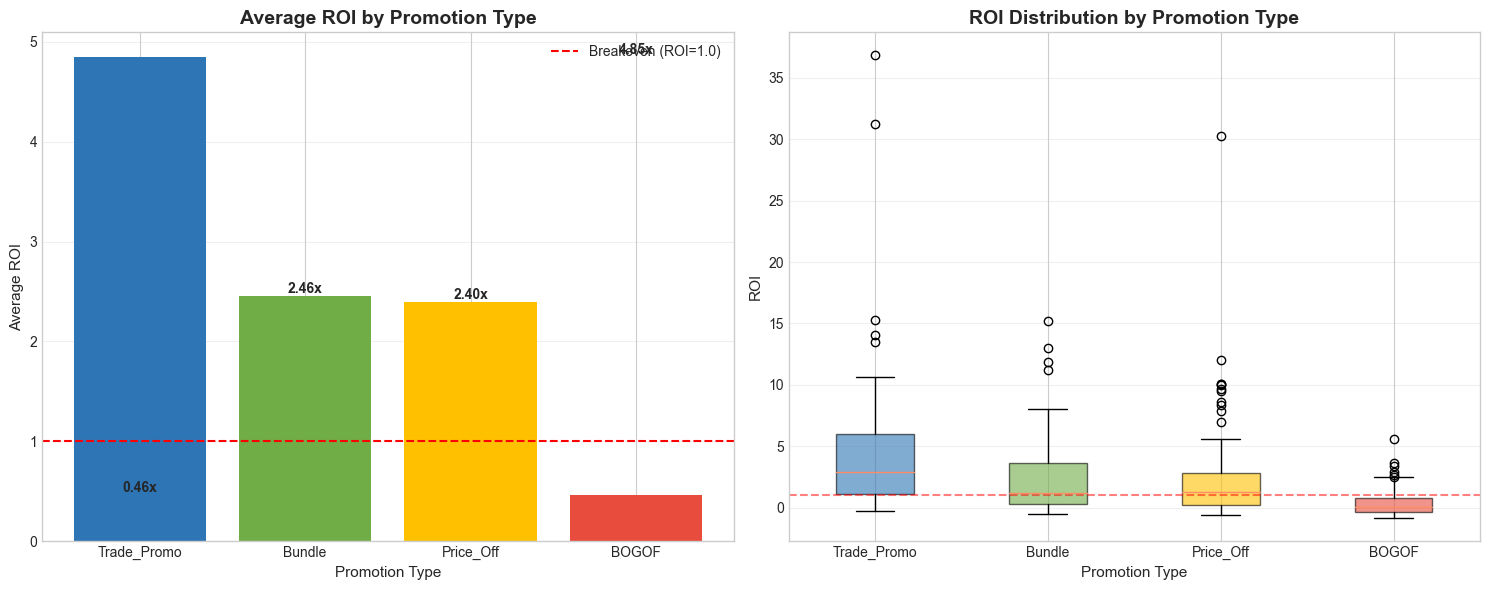

✅ ROI by promo type charts saved!


In [10]:
# ============================================================================
# VISUALIZATION 1: ROI BY PROMO TYPE
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart - Average ROI
axes[0].bar(roi_by_type['promo_type'], roi_by_type['roi_mean'], 
            color=['#2E75B5', '#70AD47', '#FFC000', '#E74C3C', '#9B59B6'])
axes[0].set_title('Average ROI by Promotion Type', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Average ROI', fontsize=11)
axes[0].set_xlabel('Promotion Type', fontsize=11)
axes[0].axhline(y=1.0, color='red', linestyle='--', label='Breakeven (ROI=1.0)')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for idx, row in roi_by_type.iterrows():
    axes[0].text(idx, row['roi_mean'], f"{row['roi_mean']:.2f}x", 
                ha='center', va='bottom', fontweight='bold')

# Box plot - ROI distribution
promo_types = roi_by_type['promo_type'].tolist()
roi_distributions = [df_promo_metrics[df_promo_metrics['promo_type'] == pt]['roi'] 
                     for pt in promo_types]

bp = axes[1].boxplot(roi_distributions, labels=promo_types, patch_artist=True)
colors = ['#2E75B5', '#70AD47', '#FFC000', '#E74C3C', '#9B59B6']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[1].set_title('ROI Distribution by Promotion Type', fontsize=14, fontweight='bold')
axes[1].set_ylabel('ROI', fontsize=11)
axes[1].set_xlabel('Promotion Type', fontsize=11)
axes[1].axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../docs/images/roi_by_promo_type.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ ROI by promo type charts saved!")

##### Discount Depth Analysis

In [11]:
# ============================================================================
# ANALYSIS 2: DISCOUNT DEPTH vs ROI
# ============================================================================

print("📊 Discount Depth Analysis...")

# Group by discount percentage
discount_analysis = df_promo_metrics.groupby('discount_percentage').agg({
    'roi': ['mean', 'count'],
    'uplift_pct': 'mean',
    'incremental_units': 'mean'
}).round(2)

discount_analysis.columns = ['_'.join(col).strip() for col in discount_analysis.columns.values]
discount_analysis = discount_analysis.reset_index()
discount_analysis = discount_analysis.sort_values('discount_percentage')

print("ROI by Discount Depth:")
print(discount_analysis.to_string(index=False))
print()

# Find optimal discount
optimal_discount = discount_analysis.loc[discount_analysis['roi_mean'].idxmax(), 'discount_percentage']
optimal_roi = discount_analysis.loc[discount_analysis['roi_mean'].idxmax(), 'roi_mean']

print(f"🎯 OPTIMAL DISCOUNT: {optimal_discount}% (ROI = {optimal_roi:.2f}x)")

📊 Discount Depth Analysis...
ROI by Discount Depth:
 discount_percentage  roi_mean  roi_count  uplift_pct_mean  incremental_units_mean
                 5.0      7.81         15            58.85                  707.67
                 8.0      2.01         14            38.01                  449.00
                10.0      4.58         39            83.77                 1287.23
                12.0      5.25         19           100.72                 1672.89
                15.0      2.38         57            88.05                 1776.56
                20.0      2.04         74           108.91                 1641.08
                25.0      1.87         18           140.21                 2278.67
                30.0      1.33         19           124.04                 1613.58
                50.0      0.46         68           176.57                 2305.18

🎯 OPTIMAL DISCOUNT: 5.0% (ROI = 7.81x)


##### Visualizing Discount Depth

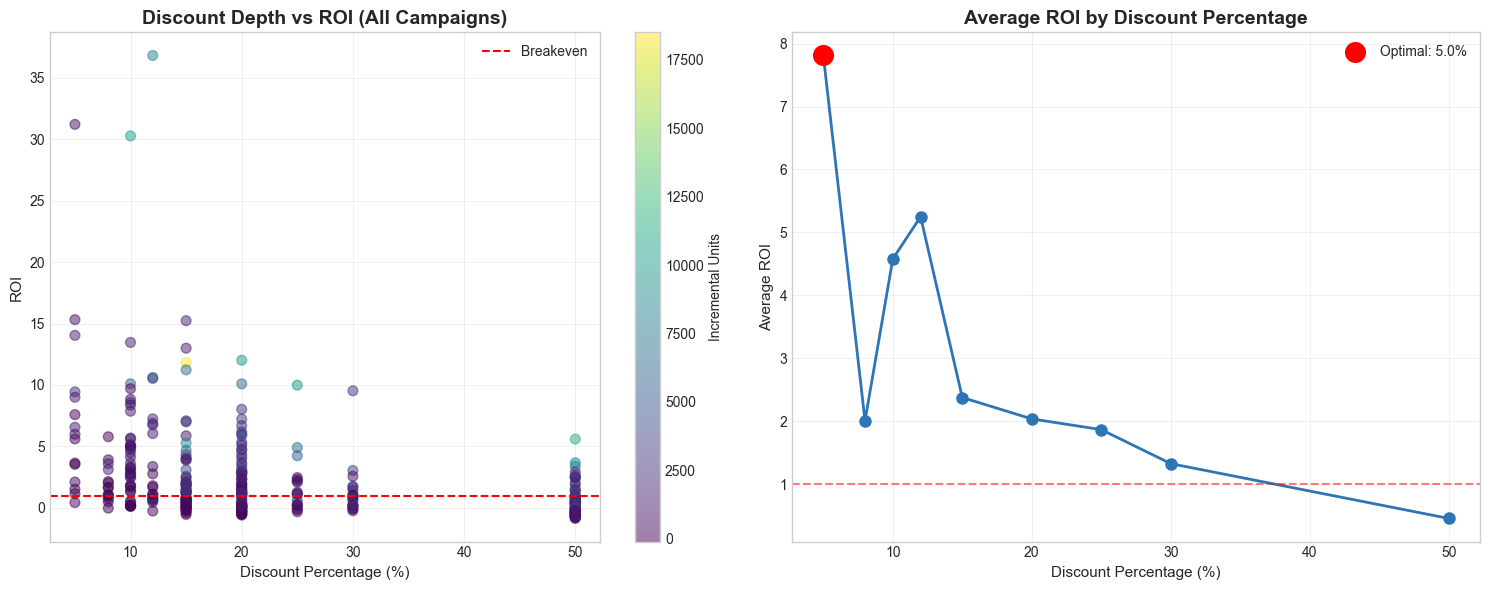

✅ Discount depth charts saved!


In [12]:
# ============================================================================
# VISUALIZATION 2: DISCOUNT DEPTH vs ROI (SCATTER + LINE)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot: All campaigns
axes[0].scatter(df_promo_metrics['discount_percentage'], 
               df_promo_metrics['roi'], 
               alpha=0.5, s=50, c=df_promo_metrics['incremental_units'], 
               cmap='viridis')
axes[0].set_title('Discount Depth vs ROI (All Campaigns)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Discount Percentage (%)', fontsize=11)
axes[0].set_ylabel('ROI', fontsize=11)
axes[0].axhline(y=1.0, color='red', linestyle='--', label='Breakeven')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Add colorbar
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Incremental Units', fontsize=10)

# Line plot: Average ROI by discount
axes[1].plot(discount_analysis['discount_percentage'], 
            discount_analysis['roi_mean'], 
            marker='o', linewidth=2, markersize=8, color='#2E75B5')
axes[1].set_title('Average ROI by Discount Percentage', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Discount Percentage (%)', fontsize=11)
axes[1].set_ylabel('Average ROI', fontsize=11)
axes[1].axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

# Highlight optimal
axes[1].scatter([optimal_discount], [optimal_roi], 
               s=200, color='red', zorder=5, label=f'Optimal: {optimal_discount}%')
axes[1].legend()

plt.tight_layout()
plt.savefig('../docs/images/discount_depth_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Discount depth charts saved!")

#### Channel Comparison

In [13]:
# ============================================================================
# ANALYSIS 3: CHANNEL EFFECTIVENESS
# ============================================================================

print("📊 Channel Comparison: Modern Trade vs Traditional Trade...")

channel_analysis = df_promo_metrics.groupby('channel_id').agg({
    'roi': ['mean', 'median', 'std', 'count'],
    'uplift_pct': 'mean',
    'total_revenue': 'sum'
}).round(2)

channel_analysis.columns = ['_'.join(col).strip() for col in channel_analysis.columns.values]
channel_analysis = channel_analysis.reset_index()

print(channel_analysis.to_string(index=False))
print()

# Statistical test
modern_roi = df_promo_metrics[df_promo_metrics['channel_id'] == 'Modern_Trade']['roi']
traditional_roi = df_promo_metrics[df_promo_metrics['channel_id'] == 'Traditional_Trade']['roi']

t_stat_ch, p_value_ch = stats.ttest_ind(modern_roi, traditional_roi)
print(f"Statistical Test: Modern Trade vs Traditional Trade")
print(f"   T-statistic: {t_stat_ch:.4f}")
print(f"   P-value: {p_value_ch:.6f}")
print(f"   Significant? {'YES' if p_value_ch < 0.05 else 'NO'}")

📊 Channel Comparison: Modern Trade vs Traditional Trade...
       channel_id  roi_mean  roi_median  roi_std  roi_count  uplift_pct_mean  total_revenue_sum
     Modern_Trade      1.06        0.31     2.09        154           111.92        217488475.2
Traditional_Trade      3.77        2.15     5.18        169           114.35        650753171.4

Statistical Test: Modern Trade vs Traditional Trade
   T-statistic: -6.0697
   P-value: 0.000000
   Significant? YES


#### Visualizing Channel Comparison

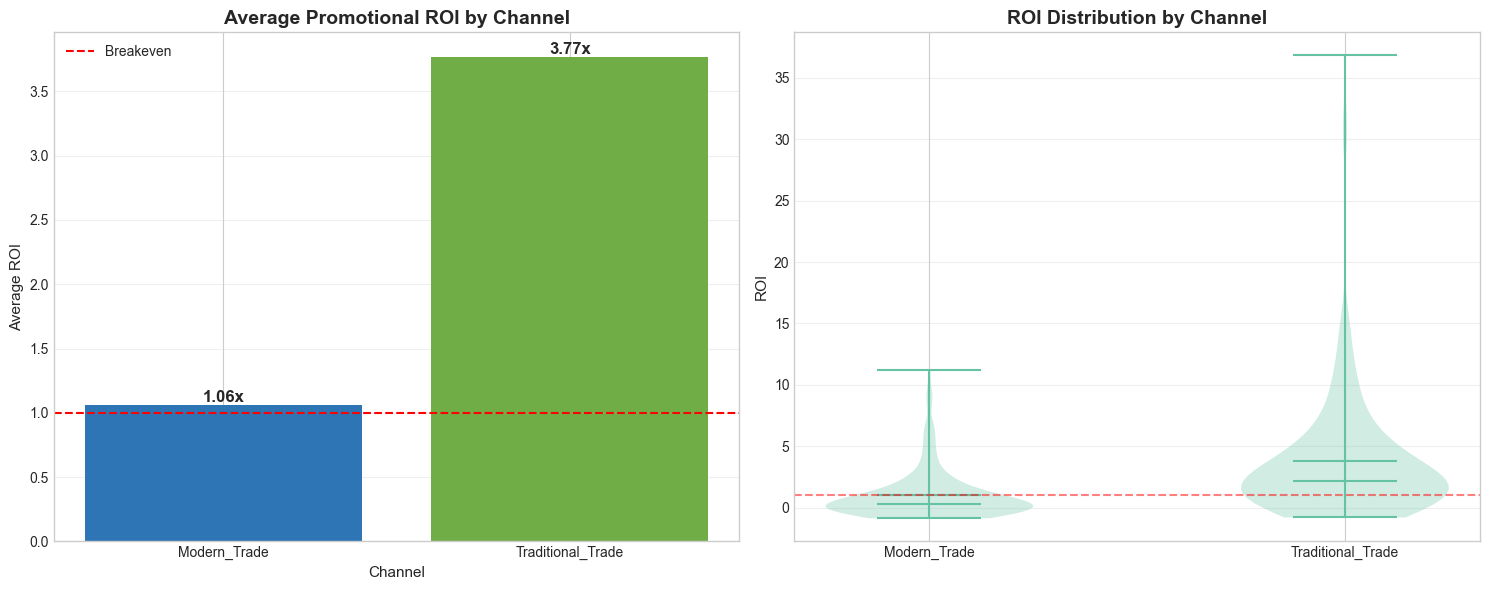

✅ Channel comparison charts saved!


In [14]:
# ============================================================================
# VISUALIZATION 3: CHANNEL COMPARISON
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart - Average ROI
axes[0].bar(channel_analysis['channel_id'], channel_analysis['roi_mean'], 
            color=['#2E75B5', '#70AD47'])
axes[0].set_title('Average Promotional ROI by Channel', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Average ROI', fontsize=11)
axes[0].set_xlabel('Channel', fontsize=11)
axes[0].axhline(y=1.0, color='red', linestyle='--', label='Breakeven')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for idx, row in channel_analysis.iterrows():
    axes[0].text(idx, row['roi_mean'], f"{row['roi_mean']:.2f}x", 
                ha='center', va='bottom', fontweight='bold', fontsize=12)

# Violin plot - ROI distribution
channel_data = [modern_roi, traditional_roi]
parts = axes[1].violinplot(channel_data, positions=[0, 1], 
                           showmeans=True, showmedians=True)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Modern_Trade', 'Traditional_Trade'])
axes[1].set_title('ROI Distribution by Channel', fontsize=14, fontweight='bold')
axes[1].set_ylabel('ROI', fontsize=11)
axes[1].axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../docs/images/channel_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Channel comparison charts saved!")

#### Category Promo Response

In [15]:
# ============================================================================
# ANALYSIS 4: CATEGORY-SPECIFIC PROMO RESPONSE
# ============================================================================

print("📊 Category-Specific Promotional Response...")

category_promo = df_promo_metrics.groupby(['category', 'promo_type']).agg({
    'roi': 'mean',
    'uplift_pct': 'mean',
    'promo_id': 'count'
}).round(2)

category_promo.columns = ['avg_roi', 'avg_uplift_pct', 'num_campaigns']
category_promo = category_promo.reset_index()
category_promo = category_promo.sort_values(['category', 'avg_roi'], ascending=[True, False])

print("Category × Promo Type Performance:")
print(category_promo.to_string(index=False))

📊 Category-Specific Promotional Response...
Category × Promo Type Performance:
category  promo_type  avg_roi  avg_uplift_pct  num_campaigns
   Dairy Trade_Promo     4.30           47.22             32
   Dairy   Price_Off     2.09           89.05             43
   Dairy      Bundle     1.32           83.36             32
   Dairy       BOGOF     0.47          149.12             32
   Juice Trade_Promo     7.07           98.38             19
   Juice      Bundle     3.44          103.88             45
   Juice   Price_Off     3.07          124.46             51
   Juice       BOGOF     0.59          201.31             22
  Snacks Trade_Promo     2.59           74.68             11
  Snacks      Bundle     1.20          128.14              6
  Snacks   Price_Off     1.11          129.04             16
  Snacks       BOGOF     0.22          200.42             14


#### Visualizing Category Response

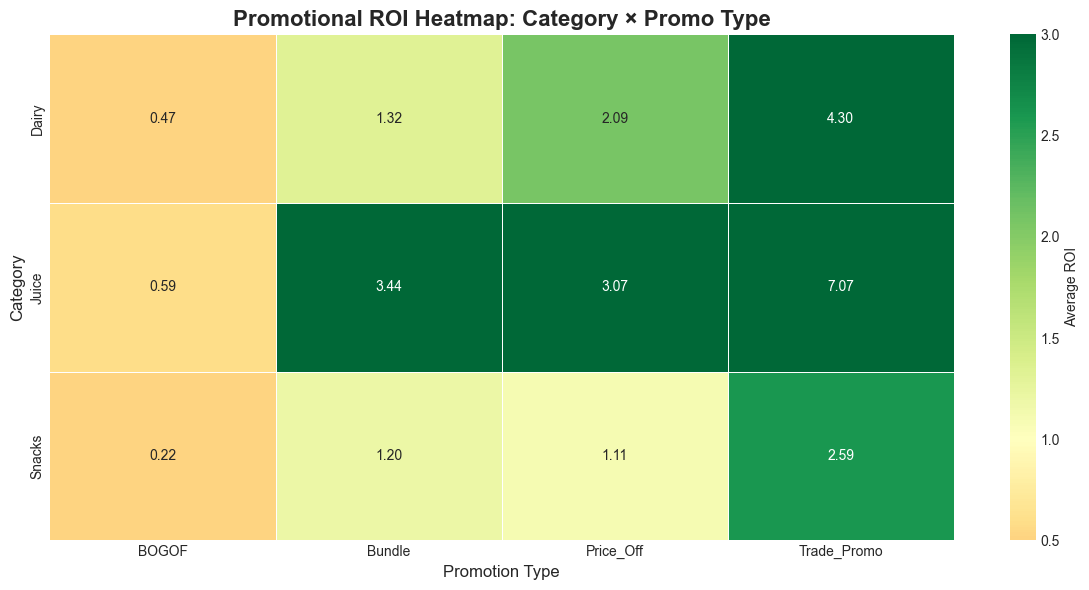

✅ Category × Promo Type heatmap saved!


In [16]:
# ============================================================================
# VISUALIZATION 4: CATEGORY × PROMO TYPE HEATMAP
# ============================================================================

# Pivot for heatmap
category_promo_pivot = category_promo.pivot(
    index='category', 
    columns='promo_type', 
    values='avg_roi'
)

plt.figure(figsize=(12, 6))
sns.heatmap(category_promo_pivot, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=1.0, vmin=0.5, vmax=3.0, 
            cbar_kws={'label': 'Average ROI'}, linewidths=0.5)
plt.title('Promotional ROI Heatmap: Category × Promo Type', fontsize=16, fontweight='bold')
plt.ylabel('Category', fontsize=12)
plt.xlabel('Promotion Type', fontsize=12)
plt.tight_layout()
plt.savefig('../docs/images/category_promo_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Category × Promo Type heatmap saved!")

#### Campaign Duration Analysis

In [17]:
# ============================================================================
# ANALYSIS 5: OPTIMAL CAMPAIGN DURATION
# ============================================================================

print("📊 Campaign Duration Analysis...")

# Round duration to weeks
df_promo_metrics['duration_rounded'] = df_promo_metrics['duration_weeks'].round(0)

duration_analysis = df_promo_metrics.groupby('duration_rounded').agg({
    'roi': ['mean', 'count'],
    'uplift_pct': 'mean',
    'cost_per_incremental_unit': 'mean'
}).round(2)

duration_analysis.columns = ['_'.join(col).strip() for col in duration_analysis.columns.values]
duration_analysis = duration_analysis.reset_index()
duration_analysis = duration_analysis.sort_values('duration_rounded')

print("ROI by Campaign Duration:")
print(duration_analysis.to_string(index=False))
print()

# Find optimal duration
optimal_duration = duration_analysis.loc[duration_analysis['roi_mean'].idxmax(), 'duration_rounded']
optimal_duration_roi = duration_analysis.loc[duration_analysis['roi_mean'].idxmax(), 'roi_mean']

print(f"🎯 OPTIMAL DURATION: {optimal_duration:.0f} weeks (ROI = {optimal_duration_roi:.2f}x)")

📊 Campaign Duration Analysis...
ROI by Campaign Duration:
 duration_rounded  roi_mean  roi_count  uplift_pct_mean  cost_per_incremental_unit_mean
              1.0      2.22         54           106.38                         1893.76
              2.0      2.52        143           121.01                         1540.39
              3.0      2.38         67           113.08                         1047.47
              4.0      2.71         59           100.60                         1283.40

🎯 OPTIMAL DURATION: 4 weeks (ROI = 2.71x)


#### Visualizing Duration Analysis

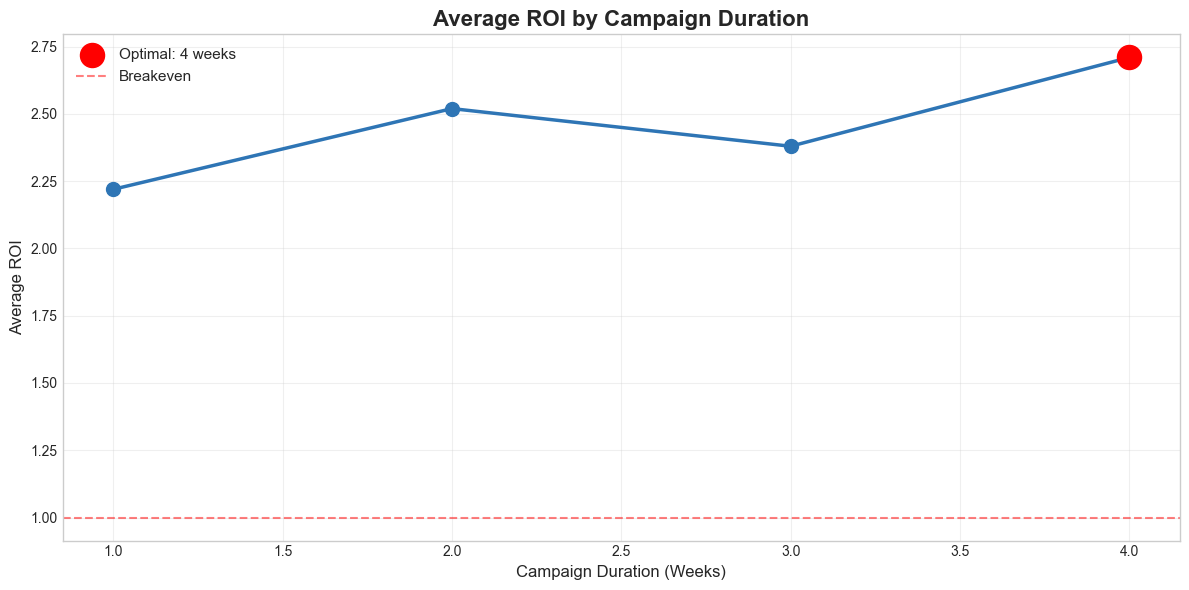

✅ Duration analysis chart saved!


In [18]:
# ============================================================================
# VISUALIZATION 5: CAMPAIGN DURATION vs ROI
# ============================================================================

plt.figure(figsize=(12, 6))
plt.plot(duration_analysis['duration_rounded'], 
        duration_analysis['roi_mean'], 
        marker='o', linewidth=2.5, markersize=10, color='#2E75B5')
plt.scatter([optimal_duration], [optimal_duration_roi], 
           s=300, color='red', zorder=5, label=f'Optimal: {optimal_duration:.0f} weeks')
plt.title('Average ROI by Campaign Duration', fontsize=16, fontweight='bold')
plt.xlabel('Campaign Duration (Weeks)', fontsize=12)
plt.ylabel('Average ROI', fontsize=12)
plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Breakeven')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('../docs/images/campaign_duration_roi.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Duration analysis chart saved!")

####  Cannibalization Detection

In [19]:
# ============================================================================
# ANALYSIS 6: CANNIBALIZATION DETECTION
# ============================================================================

print("📊 Cannibalization Analysis...")
print("Checking if promos on one product reduce sales of similar products...")
print()

# For each category, check correlation during promo weeks
cannibalization_results = []

for category in df_promo_metrics['category'].unique():
    # Get products in this category
    category_products = df_product[df_product['category'] == category]['product_id'].tolist()
    
    if len(category_products) < 2:
        continue
    
    # Get promo weeks for this category
    promo_weeks = df_promo_metrics[df_promo_metrics['category'] == category]['promo_id'].unique()
    
    # Sample analysis: Check top 2 products
    if len(category_products) >= 2:
        prod_a = category_products[0]
        prod_b = category_products[1]
        
        # Get sales data
        sales_a = df_sales[df_sales['product_id'] == prod_a].groupby('week_id')['units_sold'].sum()
        sales_b = df_sales[df_sales['product_id'] == prod_b].groupby('week_id')['units_sold'].sum()
        
        # Merge
        sales_combined = pd.DataFrame({
            'product_a': sales_a,
            'product_b': sales_b
        }).dropna()
        
        # Calculate correlation
        if len(sales_combined) > 10:
            correlation = sales_combined['product_a'].corr(sales_combined['product_b'])
            
            cannibalization_results.append({
                'category': category,
                'product_a': prod_a,
                'product_b': prod_b,
                'correlation': correlation,
                'cannibalization': 'Possible' if correlation < -0.3 else 'Unlikely'
            })

df_cannibalization = pd.DataFrame(cannibalization_results)

print("Cannibalization Analysis Results:")
print(df_cannibalization.to_string(index=False))
print()

# Interpretation
print("💡 Interpretation:")
print("   • Correlation < -0.3: Possible cannibalization (when A sells more, B sells less)")
print("   • Correlation near 0: Independent products")
print("   • Correlation > 0.3: Complementary products (sell together)")

📊 Cannibalization Analysis...
Checking if promos on one product reduce sales of similar products...

Cannibalization Analysis Results:
category       product_a       product_b  correlation cannibalization
   Juice JC-CV100-OR-200 JC-CV100-OR-500     0.964647        Unlikely
   Dairy  DR-HOLYO-ST-90 DR-HOLYO-ST-500     0.806379        Unlikely
  Snacks     SN-SUPBT-BF     SN-BEEFE-MP     0.898592        Unlikely

💡 Interpretation:
   • Correlation < -0.3: Possible cannibalization (when A sells more, B sells less)
   • Correlation near 0: Independent products
   • Correlation > 0.3: Complementary products (sell together)


## Key Insights Summary

In [20]:
# ============================================================================
# PROMOTIONAL ANALYSIS: KEY INSIGHTS
# ============================================================================

print("="*80)
print("🔑 PROMOTIONAL ANALYSIS - KEY INSIGHTS")
print("="*80)
print()

insights = []

# Insight 1: Best promo type
best_promo_type = roi_by_type.iloc[0]['promo_type']
best_promo_roi = roi_by_type.iloc[0]['roi_mean']
insight_1 = f"1. BEST PROMO TYPE: {best_promo_type} delivers {best_promo_roi:.2f}x ROI on average"
insights.append(insight_1)
print(insight_1)

# Insight 2: Optimal discount
insight_2 = f"2. OPTIMAL DISCOUNT: {optimal_discount}% discount maximizes ROI at {optimal_roi:.2f}x (higher/lower discounts reduce effectiveness)"
insights.append(insight_2)
print(insight_2)

# Insight 3: Channel difference
best_channel = channel_analysis.loc[channel_analysis['roi_mean'].idxmax(), 'channel_id']
best_channel_roi = channel_analysis.loc[channel_analysis['roi_mean'].idxmax(), 'roi_mean']
insight_3 = f"3. CHANNEL PERFORMANCE: {best_channel} shows {best_channel_roi:.2f}x ROI vs other channel"
insights.append(insight_3)
print(insight_3)

# Insight 4: Duration
insight_4 = f"4. OPTIMAL DURATION: {optimal_duration:.0f}-week campaigns maximize ROI at {optimal_duration_roi:.2f}x"
insights.append(insight_4)
print(insight_4)

# Insight 5: Category-specific
juice_best_promo = category_promo[category_promo['category'] == 'Juice'].iloc[0]
insight_5 = f"5. JUICE CATEGORY: {juice_best_promo['promo_type']} works best with {juice_best_promo['avg_roi']:.2f}x ROI"
insights.append(insight_5)
print(insight_5)

# Insight 6: Cannibalization
if len(df_cannibalization) > 0:
    cannibalization_count = (df_cannibalization['correlation'] < -0.3).sum()
    insight_6 = f"6. CANNIBALIZATION: {cannibalization_count} product pairs show possible cannibalization - avoid simultaneous promos"
    insights.append(insight_6)
    print(insight_6)

print()
print("="*80)

# Save insights
insights_df = pd.DataFrame({'insight': insights})
insights_df.to_csv('../docs/promotional_insights.csv', index=False)
print("✅ Insights saved to docs/promotional_insights.csv")

🔑 PROMOTIONAL ANALYSIS - KEY INSIGHTS

1. BEST PROMO TYPE: Trade_Promo delivers 4.85x ROI on average
2. OPTIMAL DISCOUNT: 5.0% discount maximizes ROI at 7.81x (higher/lower discounts reduce effectiveness)
3. CHANNEL PERFORMANCE: Traditional_Trade shows 3.77x ROI vs other channel
4. OPTIMAL DURATION: 4-week campaigns maximize ROI at 2.71x
5. JUICE CATEGORY: Trade_Promo works best with 7.07x ROI
6. CANNIBALIZATION: 0 product pairs show possible cannibalization - avoid simultaneous promos

✅ Insights saved to docs/promotional_insights.csv


## Saving Summary Report

In [21]:
# ============================================================================
# SAVE COMPREHENSIVE SUMMARY
# ============================================================================

# Create summary report
summary_report = {
    'Metric': [
        'Total Campaigns Analyzed',
        'Average ROI (All Promos)',
        'Best Promo Type',
        'Best Promo Type ROI',
        'Optimal Discount %',
        'Optimal Discount ROI',
        'Best Channel',
        'Best Channel ROI',
        'Optimal Duration (weeks)',
        'Optimal Duration ROI'
    ],
    'Value': [
        len(df_promo_metrics),
        f"{df_promo_metrics['roi'].mean():.2f}x",
        best_promo_type,
        f"{best_promo_roi:.2f}x",
        f"{optimal_discount}%",
        f"{optimal_roi:.2f}x",
        best_channel,
        f"{best_channel_roi:.2f}x",
        f"{optimal_duration:.0f}",
        f"{optimal_duration_roi:.2f}x"
    ]
}

df_summary = pd.DataFrame(summary_report)
df_summary.to_csv('../docs/promotional_summary.csv', index=False)

print("📊 PROMOTIONAL ANALYSIS SUMMARY")
print("="*80)
print(df_summary.to_string(index=False))
print()
print("✅ Summary saved to docs/promotional_summary.csv")

📊 PROMOTIONAL ANALYSIS SUMMARY
                  Metric             Value
Total Campaigns Analyzed               323
Average ROI (All Promos)             2.48x
         Best Promo Type       Trade_Promo
     Best Promo Type ROI             4.85x
      Optimal Discount %              5.0%
    Optimal Discount ROI             7.81x
            Best Channel Traditional_Trade
        Best Channel ROI             3.77x
Optimal Duration (weeks)                 4
    Optimal Duration ROI             2.71x

✅ Summary saved to docs/promotional_summary.csv


## Cleanup

In [24]:
# ============================================================================
# CLEANUP
# ============================================================================

conn.close()

print()
print("="*80)
print("🎉 DAY 5: PROMOTIONAL ANALYSIS COMPLETE!")
print("="*80)
print()
print("📊 Deliverables Created:")
print("   ✅ ROI analysis by promo type")
print("   ✅ Discount depth optimization")
print("   ✅ Channel comparison (Modern vs Traditional)")
print("   ✅ Category-specific promo response")
print("   ✅ Optimal campaign duration analysis")
print("   ✅ Cannibalization detection")
print("   ✅ 6 visualizations saved")
print("   ✅ Key insights + summary report")
print()
print("📁 Files Created:")
print("   • roi_by_promo_type.png")
print("   • discount_depth_analysis.png")
print("   • channel_comparison.png")
print("   • category_promo_heatmap.png")
print("   • campaign_duration_roi.png")
print("   • promotional_insights.csv")
print("   • promotional_summary.csv")
print()
print("🎉 WEEK 1 COMPLETE!")
print("="*80)
print()


🎉 DAY 5: PROMOTIONAL ANALYSIS COMPLETE!

📊 Deliverables Created:
   ✅ ROI analysis by promo type
   ✅ Discount depth optimization
   ✅ Channel comparison (Modern vs Traditional)
   ✅ Category-specific promo response
   ✅ Optimal campaign duration analysis
   ✅ Cannibalization detection
   ✅ 6 visualizations saved
   ✅ Key insights + summary report

📁 Files Created:
   • roi_by_promo_type.png
   • discount_depth_analysis.png
   • channel_comparison.png
   • category_promo_heatmap.png
   • campaign_duration_roi.png
   • promotional_insights.csv
   • promotional_summary.csv

🎉 WEEK 1 COMPLETE!

